In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

try:
    from google.colab import drive
    drive.mount('/content/drive')
    workding_dir = "/content/drive/MyDrive/logical-reasoning/"
except ModuleNotFoundError:
    workding_dir = str(Path.cwd().parent)

In [3]:
import os
import sys

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/projects/logical-reasoning


In [4]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/projects/logical-reasoning/.env


True

In [17]:
import os

model_name = os.getenv("MODEL_NAME")
adapter_name_or_path = os.getenv("ADAPTER_NAME_OR_PATH")
load_in_4bit = os.getenv("LOAD_IN_4BIT") == "true"
data_path = os.getenv("LOGICAL_REASONING_DATA_PATH")
results_path = os.getenv("LOGICAL_REASONING_RESULTS_PATH")
use_english_datasets = os.getenv("USE_ENGLISH_DATASETS") == "true"

print(model_name, adapter_name_or_path, load_in_4bit, data_path, results_path)

internlm/internlm2_5-7b-chat-1m llama-factory/saves/internlm2_5_7b/lora/sft_bf16_p2_full_r2/checkpoint-175 False datasets/mgtv results/mgtv-results_m3.csv


In [5]:
import pandas as pd

df = pd.read_csv("datasets/mgtv/train_en.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    25000 non-null  object 
 1   label   25000 non-null  object 
 2   answer  0 non-null      float64
 3   title   25000 non-null  object 
 4   puzzle  25000 non-null  object 
 5   truth   25000 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.1+ MB


In [7]:
df["label"].value_counts()

label
No                       11783
Yes                       6591
Unimportant               5076
Incorrect questioning      921
Correct answer             629
Name: count, dtype: int64

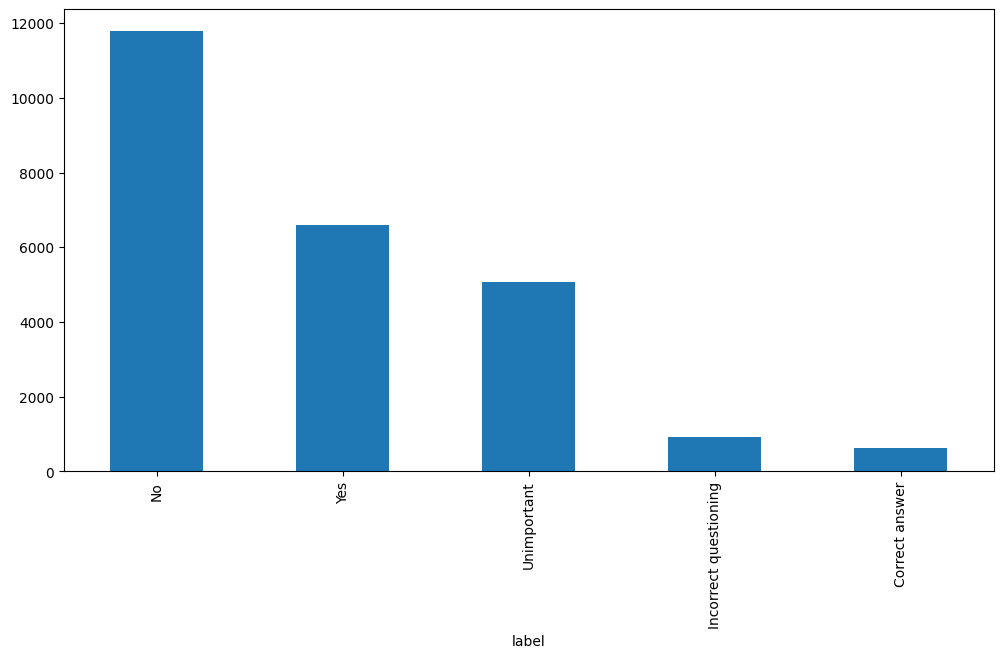

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rcParams


plt.figure(figsize=(12, 6))
df["label"].value_counts().plot(kind="bar")
plt.show()

In [9]:
df["puzzle"].value_counts()

puzzle
One night, in the dead of night, Jia Jia and his friends ran out of the longtang on their way home from work, their faces full of terror. In the distance, a trash bin, empty and overturned, lay on the ground. Jia Jia was not a resident of the longtang, nor had he caused any trouble with anyone. What was the reason for his panic?                                                                                                                                                                 10058
In the basement of an old residential building. One day, the police received a report that someone had found Zhen Haoqi's body in the basement. There were no signs of a struggle and no obvious suicide tools. The deceased was found sitting in a chair, with a calm expression, as if he had not experienced any pain before death. There was nothing in the basement except for a TV and a table. There was a glass of water on the table, and the TV was still on. What caused Zhen Haoqi's death?     9345

In [10]:
df["truth"].value_counts()

truth
It turned out that Jia Qijia was a petty thief on the run. That night, he was trying to find a target to steal from in the alley. But he was so scared that he didn't even notice a wild cat suddenly jumping out of the trash bin and scaring him. Thinking that the police had caught him, he ran away in a panic. The trash bin was where he had accidentally knocked over while searching for something.                                                                                                                                                                                                                                                                                                                                                10058
Although he was a science fiction author, Jindao suffered from severe claustrophobia. He often went to the underground room alone to watch science fiction movies in the hope of finding inspiration. Unfortunately, one day he was watching a movie when the po

In [11]:
len(df["title"].value_counts()), len(df["puzzle"].value_counts()), len(df["truth"].value_counts())

(16, 16, 16)

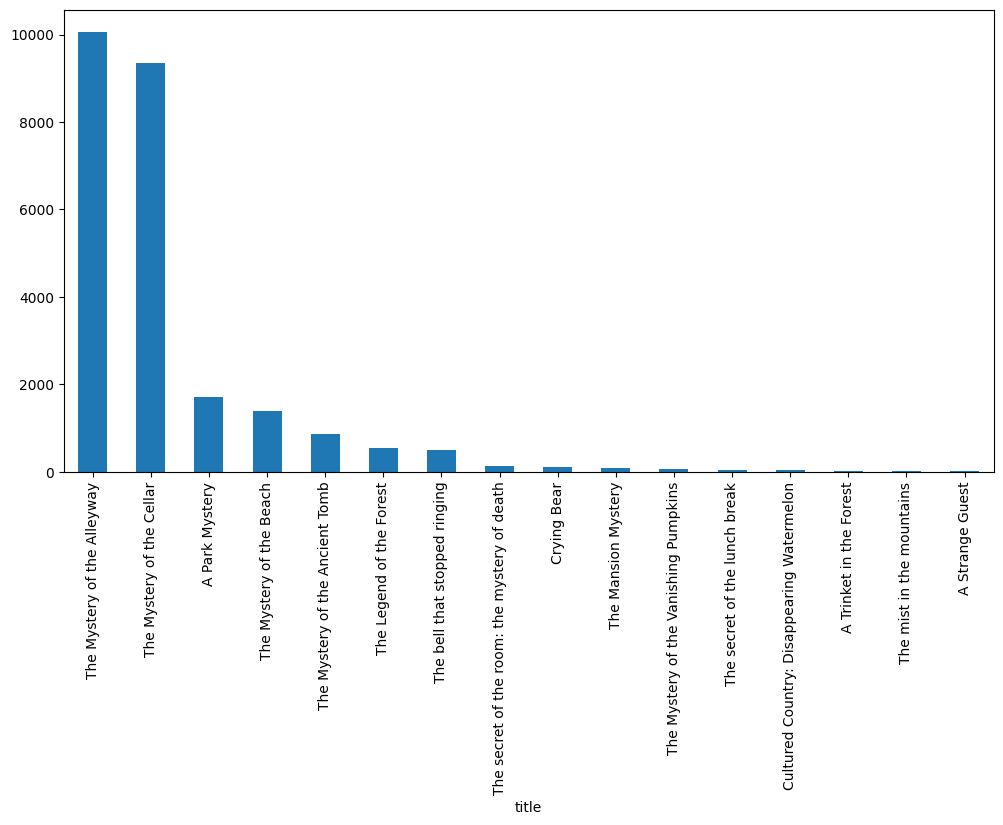

In [12]:
import matplotlib.pyplot as plt
from matplotlib import rcParams


plt.figure(figsize=(12, 6))
df["title"].value_counts().plot(kind="bar")
plt.show()

In [13]:
df_dev = pd.read_csv("datasets/mgtv/dev_en.csv")
len(df_dev["title"].value_counts()), len(df_dev["puzzle"].value_counts()), len(
    df_dev["truth"].value_counts()
)

(5, 5, 5)

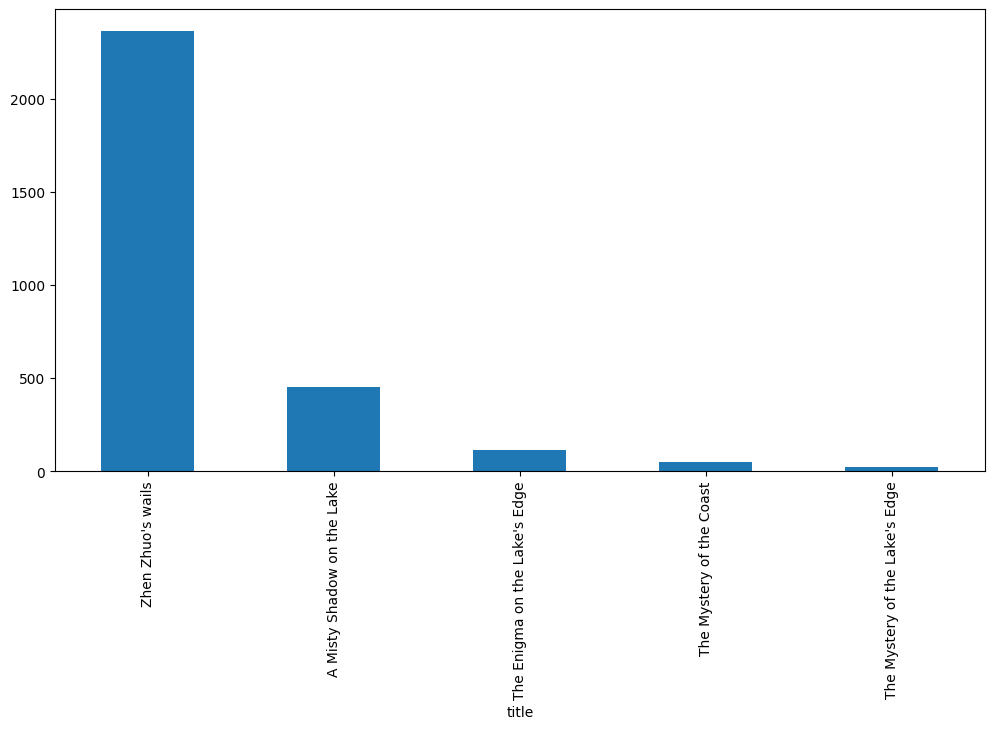

In [14]:
import matplotlib.pyplot as plt
from matplotlib import rcParams


plt.figure(figsize=(12, 6))
df_dev["title"].value_counts().plot(kind="bar")
plt.show()

In [15]:
# print details of the first row
for col in df_dev.columns:
    print("-" * 50)
    print(f"{col}: {df_dev[col].iloc[0]}")

--------------------------------------------------
text: Was Zhen Zhesuo suicide?
--------------------------------------------------
label: No
--------------------------------------------------
answer: nan
--------------------------------------------------
title: The Mystery of the Coast
--------------------------------------------------
puzzle: In the quiet seaside cottage of a neighbor, a morning in which a body was found on the beach, the cause of death was never determined.
--------------------------------------------------
truth: Zhen Zhesao was a nature-loving painter who came to this coastal cottage every year to find inspiration. In his final days, he was working on a painting of marine life. The day before the painting was finished, he went out on his bike to watch the night scene at the beach. However, he found a stranded dolphin on the beach and spent a lot of energy trying to rescue it. Exhausted, he fell asleep on the beach, having a heart condition that was so severe that

In [27]:
from llm_toolkit.logical_reasoning_utils import load_alpaca_data
from llm_toolkit.llm_utils import print_row_details

loading /Users/inflaton/code/engd/projects/logical-reasoning/llm_toolkit/logical_reasoning_utils.py


In [26]:
alpaca_p1 = load_alpaca_data(data_path, using_p1=True, use_english_datasets=False)
print_row_details(alpaca_p1, [0])

loading existing data from: llama-factory/data/alpaca_mgtv_p1.json
--------------------------------------------------
instruction: 你是一个逻辑游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜题。
2. 参与者可以通过提问来获取线索，尝试解开谜题。
3. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。
4. 回答中不能添加任何其它信息，也不能省略选项中的任何一个字。例如，不可以把“不是”省略成“不”。
5. 参与者需要根据回答来推理，并最终找出谜题的正确答案。

请严格按照这些规则回答参与者提出的问题。

谜题: 在甄家村里，有一个古老的传说：每年南瓜丰收的季节，南瓜田里总有一个最大的南瓜会不翼而飞，村民们对此现象困惑不解。请找出南瓜失踪背后的原因。

实际情况: 真相原来与一位年迈的农夫有关。这位农夫年轻时，曾与一位美丽的姑娘相恋。他们约定在南瓜丰收的季节结婚。然而，命运弄人，姑娘在婚礼前的一场意外中离世。悲伤的农夫为了纪念心爱的姑娘，每年都会将最大的南瓜偷走，放到姑娘的墓前，以此寄托自己的哀思。这一行为延续了多年，成为了乡村里一个神秘的传说。

参与者提出的问题: 偷的人信神吗

--------------------------------------------------
input: 
--------------------------------------------------
output: 不是


In [25]:
alpaca_p2 = load_alpaca_data(data_path, using_p1=False, use_english_datasets=False)
print_row_details(alpaca_p2, [0])

loading existing data from: llama-factory/data/alpaca_mgtv_p2.json
--------------------------------------------------
instruction: 你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：
   - 若谜面和谜底能找到问题的答案，回答：是或者不是
   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要
   - 若参与者提问不是一个封闭式问题或者问题难以理解，回答：问法错误
   - 若参与者提问基本还原了谜底真相，回答：回答正确
5. 回答中不能添加任何其它信息，也不能省略选项中的任何一个字。例如，不可以把“不是”省略成“不”。

请严格按照这些规则回答参与者提出的问题。

**谜面:** 在甄家村里，有一个古老的传说：每年南瓜丰收的季节，南瓜田里总有一个最大的南瓜会不翼而飞，村民们对此现象困惑不解。请找出南瓜失踪背后的原因。

**谜底:** 真相原来与一位年迈的农夫有关。这位农夫年轻时，曾与一位美丽的姑娘相恋。他们约定在南瓜丰收的季节结婚。然而，命运弄人，姑娘在婚礼前的一场意外中离世。悲伤的农夫为了纪念心爱的姑娘，每年都会将最大的南瓜偷走，放到姑娘的墓前，以此寄托自己的哀思。这一行为延续了多年，成为了乡村里一个神秘的传说。

**参与者提出的问题:** 偷的人信神吗

--------------------------------------------------
input: 
--------------------------------------------------
output: 不是


In [30]:
alpaca_p1_en = load_alpaca_data(data_path, using_p1=True, use_english_datasets=True)
print_row_details(alpaca_p1_en, [0])

loading new data from: llama-factory/data/alpaca_mgtv_p1_en.json
loading train/test data files
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'answer', 'title', 'puzzle', 'truth'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'answer', 'title', 'puzzle', 'truth'],
        num_rows: 3000
    })
})
--------------------------------------------------
instruction: You are the host of a logic game. The rules of the game are as follows:

	1.	Participants will receive a puzzle.
	2.	Participants can ask questions to obtain clues and try to solve the puzzle.
	3.	For each question, the host will answer with one of the following five options based on the actual situation: Yes, No, Unimportant, Correct answer, or Incorrect questioning.
	4.	The answer cannot include any additional information, nor can any word in the options be omitted. For example, “No” cannot be shortened to “N”.
	5.	Participants need to infer and ultimately find th

In [29]:
alpaca_p2_en = load_alpaca_data(data_path, using_p1=False, use_english_datasets=True)
print_row_details(alpaca_p2_en, [0])

loading /Users/inflaton/code/engd/projects/logical-reasoning/llm_toolkit/logical_reasoning_utils.py
loading new data from: llama-factory/data/alpaca_mgtv_p2_en.json
loading train/test data files
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'answer', 'title', 'puzzle', 'truth'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'answer', 'title', 'puzzle', 'truth'],
        num_rows: 3000
    })
})
--------------------------------------------------
instruction: You are the host of a situational guessing game. The rules of the game are as follows:

1. Participants will receive a riddle that describes a simple yet difficult to understand event.
2. The host knows the answer, which is the solution to the riddle.
3. Participants can ask any closed-ended questions to uncover the truth of the event.
4. For each question, the host will respond with one of the following five options based on the actual situation: Yes, No, Unimportant